# Load necessary libraries

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score


In [2]:
df = pd.read_csv('quantvision_financial_dataset_200.csv') # load dataset

df.head() # first 5 rows

,lookback_days,asset_type,market_regime,high_volatility,trend_continuation,technical_score,edge_density,slope_strength,candlestick_variance,pattern_symmetry,future_trend
0,48,equity,bullish,0,1,59.99,0.504,0.298,1.572,0.768,1
1,38,index,bullish,1,1,78.54,0.559,0.037,0.692,0.538,1
2,24,equity,bullish,1,0,56.03,0.617,0.212,1.419,0.301,1
3,52,equity,bullish,0,0,66.51,0.360,0.347,0.699,0.498,1
4,17,equity,bullish,1,1,61.21,0.492,0.144,2.520,0.828,1


In [3]:
df.tail() # last 5 rows

,lookback_days,asset_type,market_regime,high_volatility,trend_continuation,technical_score,edge_density,slope_strength,candlestick_variance,pattern_symmetry,future_trend
195,48,index,bullish,1,1,71.27,0.515,-0.285,1.614,0.774,0
196,15,equity,bullish,1,0,39.32,0.421,-0.037,2.009,0.506,1
197,17,index,bullish,1,0,52.31,0.624,-0.629,2.049,0.523,0
198,36,equity,bullish,1,1,66.78,0.523,-0.628,1.246,1.000,1
199,18,index,bearish,1,1,59.52,0.566,0.828,2.228,0.841,1


In [4]:
continous_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Continuous columns:", continous_columns)
print("Categorical columns:", categorical_columns)

Continuous columns: Index(['lookback_days', 'high_volatility', 'trend_continuation',
       'technical_score', 'edge_density', 'slope_strength',
       'candlestick_variance', 'pattern_symmetry', 'future_trend'],
      dtype='object')
Categorical columns: Index(['asset_type', 'market_regime'], dtype='object')


In [5]:
df.info() # dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lookback_days         200 non-null    int64  
 1   asset_type            200 non-null    object 
 2   market_regime         200 non-null    object 
 3   high_volatility       200 non-null    int64  
 4   trend_continuation    200 non-null    int64  
 5   technical_score       200 non-null    float64
 6   edge_density          200 non-null    float64
 7   slope_strength        200 non-null    float64
 8   candlestick_variance  200 non-null    float64
 9   pattern_symmetry      200 non-null    float64
 10  future_trend          200 non-null    int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 17.3+ KB


In [6]:
df.describe() # statistical summary

,lookback_days,high_volatility,trend_continuation,technical_score,edge_density,slope_strength,candlestick_variance,pattern_symmetry,future_trend
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,34.635000,0.360000,0.610000,61.846850,0.464105,0.250510,1.279245,0.613830,0.935000
std,14.656598,0.481205,0.488974,15.028468,0.116050,0.619966,0.575535,0.173577,0.247144
min,10.000000,0.000000,0.000000,24.200000,0.191000,-1.217000,0.028000,0.210000,0.000000
25%,22.000000,0.000000,0.000000,51.055000,0.384000,-0.174000,0.838000,0.483000,1.000000
50%,35.000000,0.000000,1.000000,61.570000,0.444500,0.273500,1.264000,0.601500,1.000000
75%,48.000000,1.000000,1.000000,72.122500,0.531500,0.696750,1.663250,0.745250,1.000000
max,60.000000,1.000000,1.000000,100.000000,0.798000,1.833000,2.520000,1.000000,1.000000


### Basic Sanity Check

- Check for null count
- Check for duplicated rows
- Check for Predictor Variable (Trend Continution) distibution

In [7]:
# null counts
print(df.isnull().sum())

lookback_days           0
asset_type              0
market_regime           0
high_volatility         0
trend_continuation      0
technical_score         0
edge_density            0
slope_strength          0
candlestick_variance    0
pattern_symmetry        0
future_trend            0
dtype: int64


In [8]:
# Duplicate rows
print('Duplicated rows:',df.duplicated().sum())

# Target distribution
df['future_trend'].value_counts(normalize=True)

Duplicated rows: 0


future_trend
1    0.935
0    0.065
Name: proportion, dtype: float64

<Axes: xlabel='future_trend'>

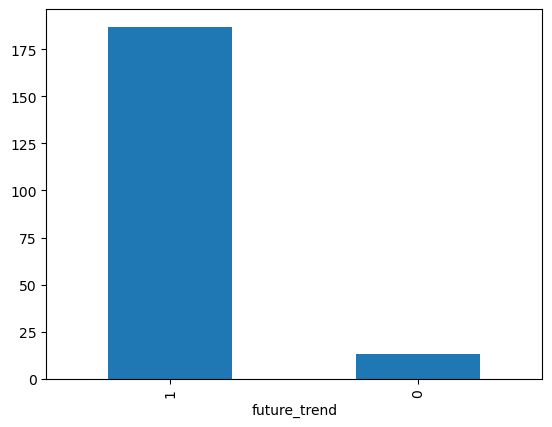

In [9]:
df['future_trend'].value_counts().plot(kind='bar') # predictor variable distribution

> **Conclusion:** From sanity check following are observations made
> - _no.of nulls = 0_
> - _no.of duplicates = 0_
> - _predictor variable is skewed_ => dataset is highly imbalanced, since future_trend has proprotions of 0.935 and 0.065 for values 1 and 0


# 4.1 EDA

In [10]:
# divide features and target

target = 'future_trend'

categorical_features = ['asset_type', 'market_regime']
binary_features = ['high_volatility', 'trend_continuation']
numerical_features = [
    'lookback_days',
    'technical_score',
    'edge_density',
    'slope_strength',
    'candlestick_variance',
    'pattern_symmetry'
]

### EDA on numerical_features


Feature: lookback_days
  1: 0 outliers
  0: 0 outliers

Feature: technical_score
  1: 0 outliers
  0: 1 outliers
     technical_score
195            71.27

Feature: edge_density
  1: 2 outliers
     edge_density
102         0.798
104         0.757
  0: 1 outliers
    edge_density
23         0.201

Feature: slope_strength
  1: 0 outliers
  0: 1 outliers
     slope_strength
168           0.696

Feature: candlestick_variance
  1: 0 outliers
  0: 0 outliers

Feature: pattern_symmetry
  1: 0 outliers
  0: 1 outliers
     pattern_symmetry
195             0.774


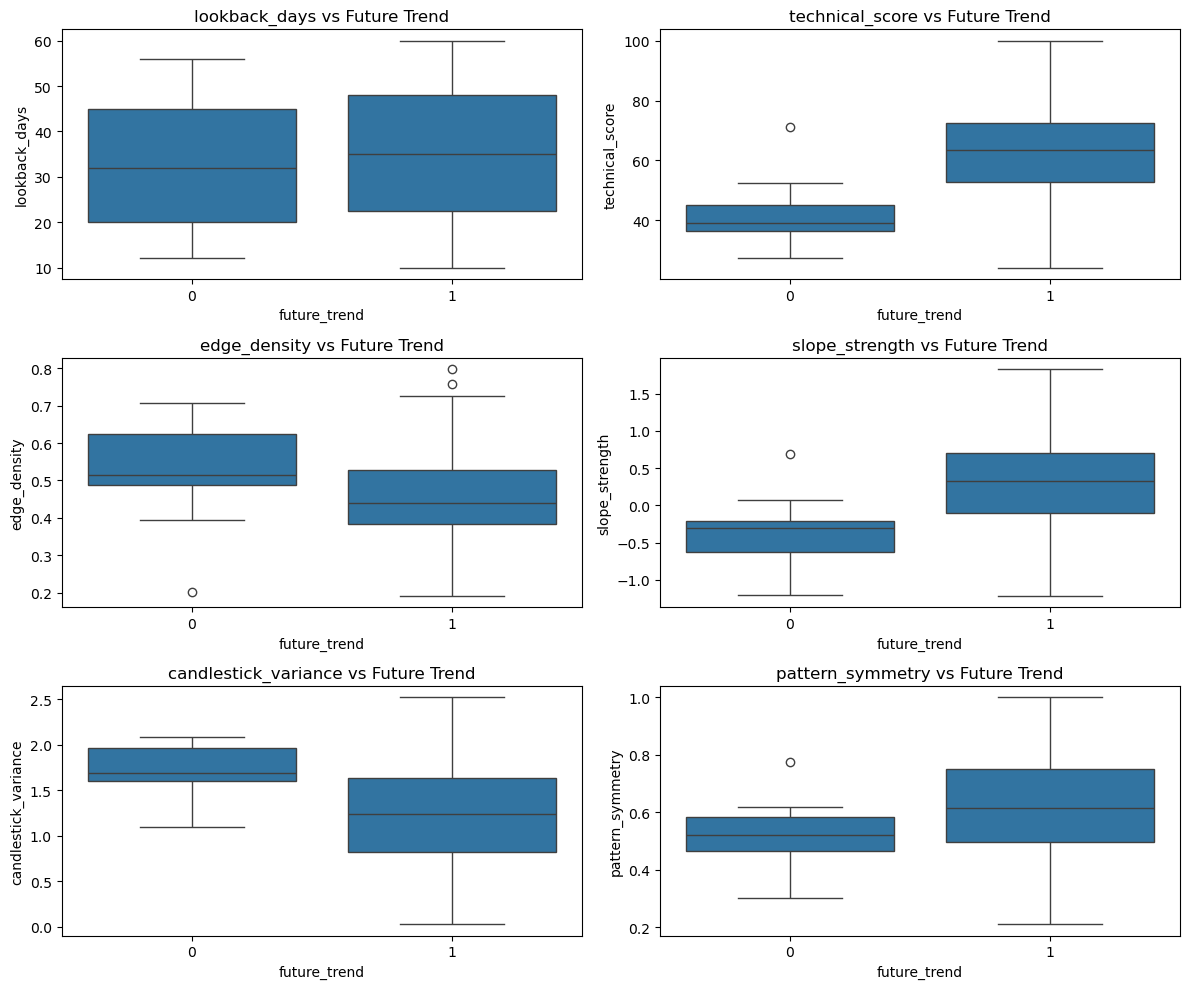

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(
        x='future_trend',
        y=col,
        data=df,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs Future Trend")

    print(f"\nFeature: {col}")

    for trend in df['future_trend'].unique():
        subset = df[df['future_trend'] == trend][col]

        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[
            (df['future_trend'] == trend) &
            ((df[col] < lower) | (df[col] > upper))
        ]

        print(f"  {trend}: {len(outliers)} outliers")

        if not outliers.empty:
            print(outliers[[col]])

plt.tight_layout()
plt.show()

## Numerical Features — Final Analysis

### Features analyzed

* `lookback_days`
* `technical_score`
* `edge_density`
* `slope_strength`
* `candlestick_variance`
* `pattern_symmetry`

### What was done

* Boxplots were created **grouped by the target (`future_trend`)**
* Outliers were detected using the **IQR method per class**
* This matched seaborn’s boxplot logic (class-wise quartiles)

### Key observations

* Most numerical features are **well-behaved**
* Outliers are **rare and class-specific**, not global
* `edge_density` shows the most extreme values across both classes
* Other features have at most **1–2 isolated outliers**

### Interpretation

* These outliers appear to be **valid observations**, not data errors
* There is no evidence of systematic contamination or heavy tails
* Global outlier removal would be inappropriate

### Modeling implications

* Numerical features are **safe to keep**
* Standard scaling is required
* Regularized logistic regression will naturally limit outlier influence
* No feature should be dropped solely due to outliers

### Conclusion

Numerical features are clean, informative, and suitable for logistic regression with scaling and regularization.

---

### EDA on categorical_features


Counts for feature: asset_type
future_trend  0   1
asset_type         
crypto        3  38
equity        6  99
index         4  50

Total per class:
future_trend
0     13
1    187
dtype: int64

Counts for feature: market_regime
future_trend   0   1
market_regime       
bearish        4  56
bullish        5  78
sideways       4  53

Total per class:
future_trend
0     13
1    187
dtype: int64


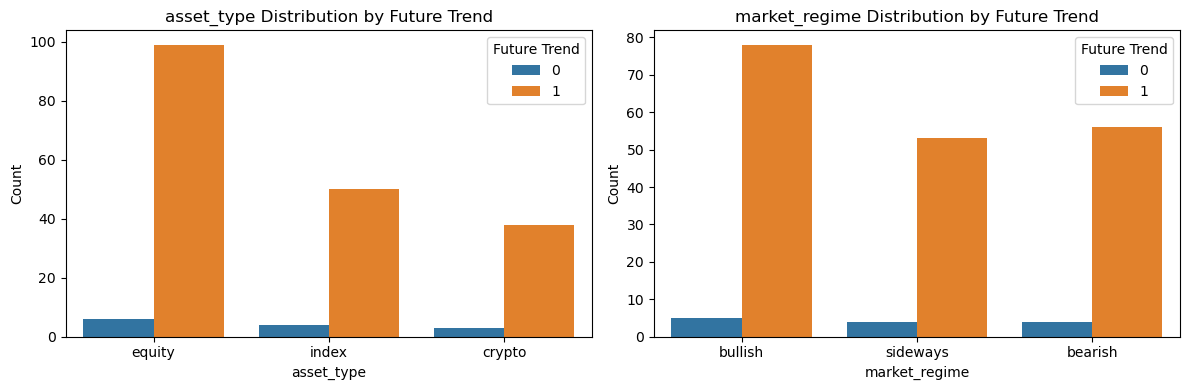

In [12]:
fig, axes = plt.subplots(
    1, len(categorical_features),
    figsize=(6 * len(categorical_features), 4)
)

# Ensure axes is iterable
if len(categorical_features) == 1:
    axes = [axes]

for i, col in enumerate(categorical_features):
    # ---- PLOT ----
    sns.countplot(
        x=col,
        hue='future_trend',
        data=df,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} Distribution by Future Trend")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Future Trend')

    # ---- PRINT COUNTS ----
    print(f"\nCounts for feature: {col}")

    # Category × class counts
    ct = pd.crosstab(df[col], df['future_trend'])
    print(ct)

    # Total counts per class (for this feature)
    print("\nTotal per class:")
    print(ct.sum())

plt.tight_layout()
plt.show()


## Categorical Features — Final Analysis

### Features analyzed

* `asset_type`
* `market_regime`

### What was done

* Count plots grouped by `future_trend`
* Cross-tabulation to inspect class distributions

### Key observations

* All categories appear in **both classes**
* No category perfectly predicts the target
* Distributions across categories are broadly similar
* Class imbalance dominates category counts

### Critical finding

* The target variable is **severely imbalanced**

  * Class `1`: 187 samples
  * Class `0`: 13 samples

### Interpretation

* Categorical features themselves are **not problematic**
* The imbalance means their apparent effect may be overstated or understated
* There is no evidence of data leakage or category exclusivity

### Modeling implications

* One-hot encoding is appropriate
* Class weighting is required
* Coefficients should be interpreted cautiously
* Accuracy is not a meaningful metric here

### Conclusion

Categorical features are structurally sound, but their usefulness depends on handling target imbalance correctly.

---


### EDA on binary_features


Counts for feature: high_volatility
future_trend      0    1
high_volatility         
0                 1  127
1                12   60

Total per class:
future_trend
0     13
1    187
dtype: int64

Counts for feature: trend_continuation
future_trend         0    1
trend_continuation         
0                   12   66
1                    1  121

Total per class:
future_trend
0     13
1    187
dtype: int64


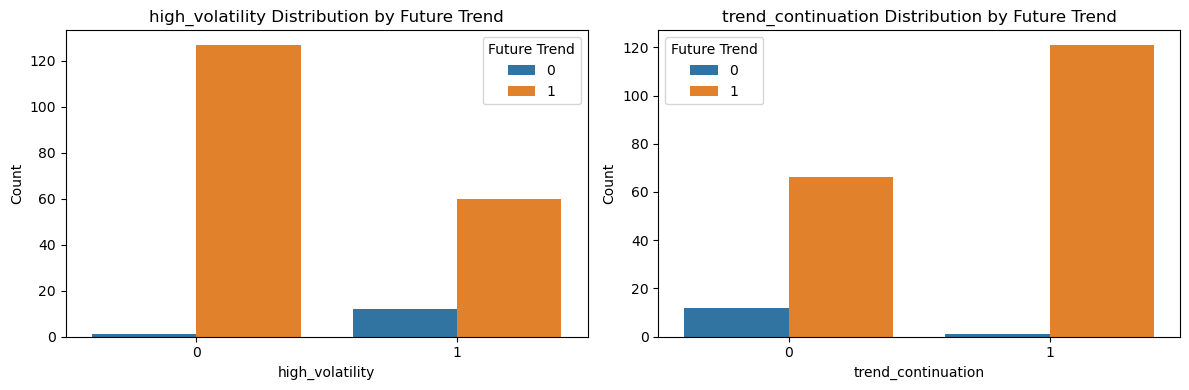

In [13]:
fig, axes = plt.subplots(
    1, len(binary_features),
    figsize=(6 * len(binary_features), 4)
)

# Ensure axes is iterable
if len(binary_features) == 1:
    axes = [axes]

for i, col in enumerate(binary_features):
    # ---- PLOT ----
    sns.countplot(
        x=col,
        hue='future_trend',
        data=df,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} Distribution by Future Trend")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Future Trend')

    # ---- PRINT COUNTS ----
    print(f"\nCounts for feature: {col}")

    # Category × class counts
    ct = pd.crosstab(df[col], df['future_trend'])
    print(ct)

    # Total counts per class (for this feature)
    print("\nTotal per class:")
    print(ct.sum())

plt.tight_layout()
plt.show()

## Binary Features — Final Analysis

### Features analyzed

* `high_volatility`
* `trend_continuation`

### What was done

* Cross-tabulated binary values against `future_trend`
* Inspected cell counts for separation risk

### Key observations

* Both features show **strong association** with the target
* Minority class observations are concentrated in specific binary states
* Some cells contain **very small counts (1–2 samples)**

### Interpretation

* These features are **highly informative**
* However, they introduce **quasi-complete separation risk**
* Coefficients may become unstable without constraints

### Modeling implications

* These features should **not be removed**
* Strong regularization is required
* Class-weighted logistic regression is mandatory
* Coefficient magnitudes must be monitored

### Conclusion

Binary features carry the strongest signal in the dataset but must be handled with care to avoid overfitting and unstable estimates.

---


## Overall Summary

* Numerical features are clean and stable
* Categorical features are valid but overshadowed by class imbalance
* Binary features provide strong signal with separation risk
* The dominant issue is **target imbalance**, not feature quality

### Recommended modeling setup

* Standardize numerical features
* One-hot encode categorical features
* Use **class-weighted, regularized logistic regression**
* Evaluate using recall, precision, and ROC-AUC — not accuracy


---

# Advanced EDA and Pre-Processing

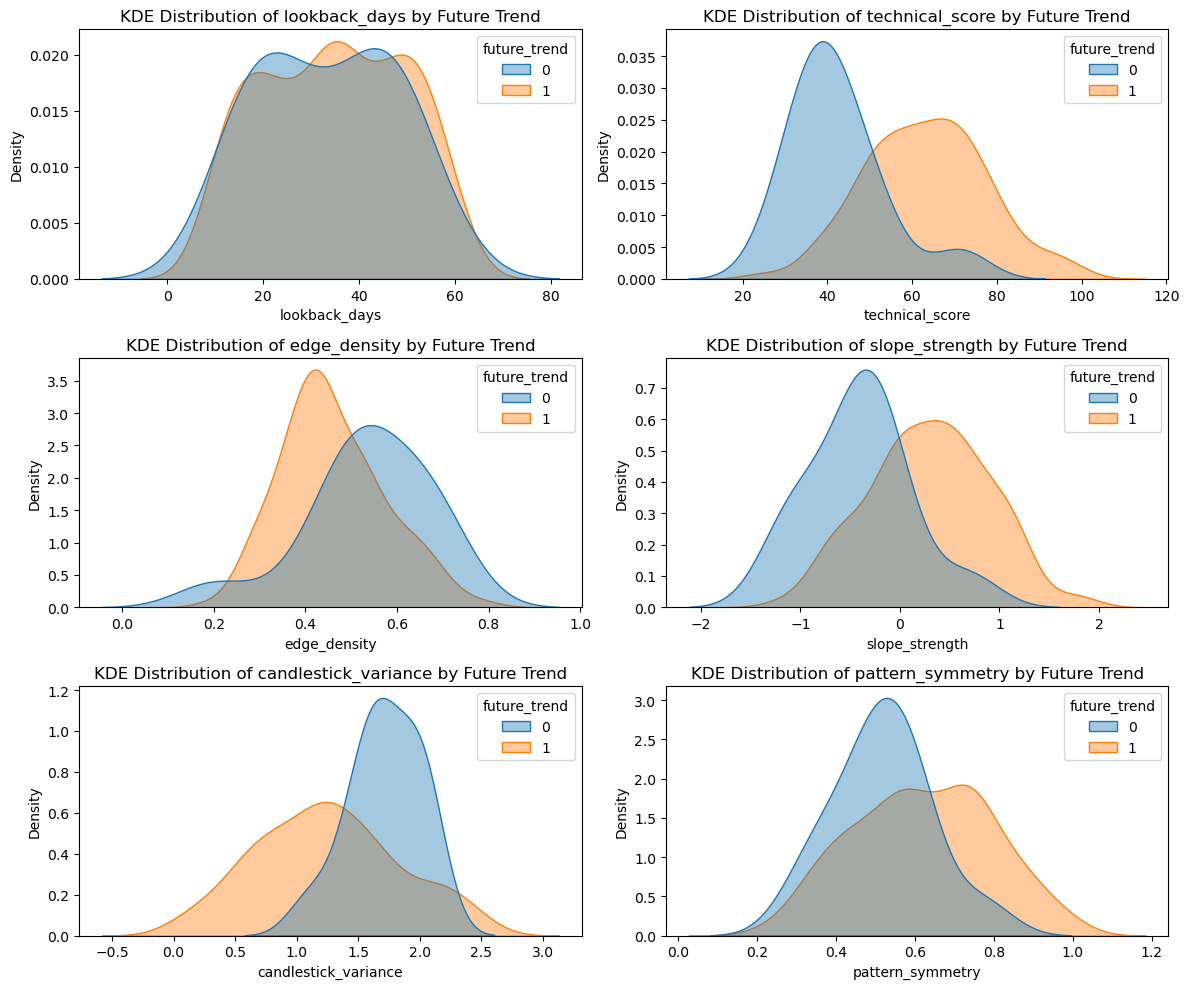

In [14]:
# kde plots for numerical features

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.kdeplot(
        data=df,
        x=col,
        hue='future_trend',
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=axes[i]
    )
    axes[i].set_title(f"KDE Distribution of {col} by Future Trend")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()




## KDE Distribution Analysis (Feature vs Target)

### Lookback Days vs Future Trend

* KDE plots show **two distinct peaks for both classes (0 and 1)**.
* Indicates **multi-modal behavior**:

  * Different trading horizons (short-term vs mid-term) influence price movement.
* Heavy overlap between classes → **weak standalone predictor**.
* Suggests **interaction effects** with other features (e.g., regime, volatility).

 **Interpretation**
Lookback_days alone does not strongly separate up/down moves but may be useful when combined with **market regime or trend continuation**.

---

###  Trend Continuation (Binary)

* Both classes present in both states (0/1).
* Slight skew towards `future_trend = 1` when continuation = 1.
* Not deterministic → **probabilistic influence only**.

**Interpretation**
Trend continuation increases likelihood of upside but **cannot be used as a rule-based signal**.

---

###  Other Numerical Features (General KDE Behavior)

* Distributions show:

  * **Moderate skewness**
  * **Long right tails**
* Heavy overlap across classes.
* No feature exhibits a clean, single-mode separation.

**Interpretation**
This confirms:

* Linear separation is weak
* **Non-linear models** (tree-based, boosting) are more suitable than pure linear models.

---

## Distribution Shape Implications (Model Choice)

| Observation               | Modeling Impact             |
| ------------------------- | --------------------------- |
| Multi-modal distributions | Linear models struggle      |
| Long-tailed features      | Scaling required            |
| Overlapping KDEs          | Need ensemble / boosting    |
| Weak marginal separation  | Feature interactions matter |

**Decision**

Use:

* Gradient Boosting / XGBoost
* Feature interaction-aware models
* Probability-based outputs (not hard rules)

---

In [15]:
# pearson correlation matrix

corr_pearson = df[numerical_features].corr(method='pearson')

print("Pearson Correlation Matrix")
corr_pearson.round(3)

Pearson Correlation Matrix


,lookback_days,technical_score,edge_density,slope_strength,candlestick_variance,pattern_symmetry
lookback_days,1.000,0.040,-0.060,-0.125,-0.077,0.018
technical_score,0.040,1.000,-0.161,0.403,-0.257,0.347
edge_density,-0.060,-0.161,1.000,-0.113,0.415,-0.023
slope_strength,-0.125,0.403,-0.113,1.000,-0.139,0.267
candlestick_variance,-0.077,-0.257,0.415,-0.139,1.000,-0.021
pattern_symmetry,0.018,0.347,-0.023,0.267,-0.021,1.000


In [16]:
# spearman correlation

corr_spearman = df[numerical_features].corr(method='spearman')

print("\nSpearman Correlation Matrix")
corr_spearman.round(3)


Spearman Correlation Matrix


,lookback_days,technical_score,edge_density,slope_strength,candlestick_variance,pattern_symmetry
lookback_days,1.000,0.027,-0.048,-0.111,-0.068,0.017
technical_score,0.027,1.000,-0.150,0.414,-0.248,0.362
edge_density,-0.048,-0.150,1.000,-0.115,0.426,-0.024
slope_strength,-0.111,0.414,-0.115,1.000,-0.151,0.245
candlestick_variance,-0.068,-0.248,0.426,-0.151,1.000,-0.029
pattern_symmetry,0.017,0.362,-0.024,0.245,-0.029,1.000


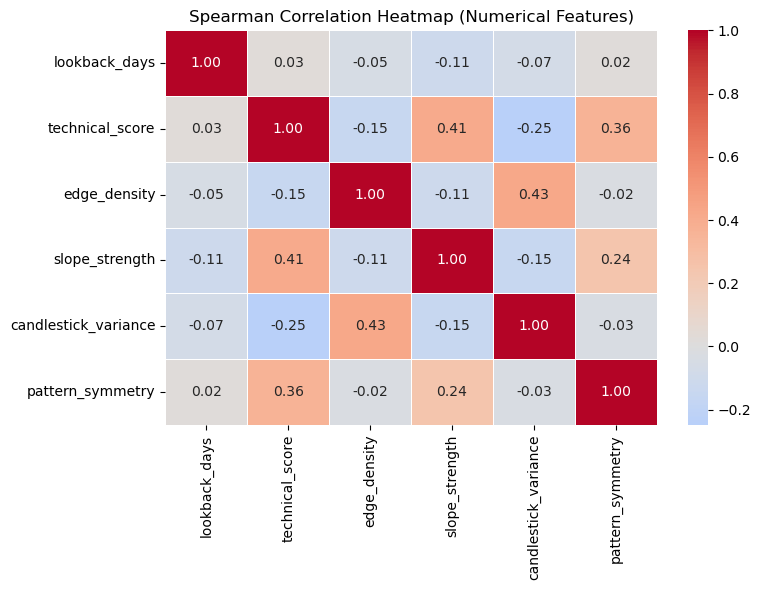

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_spearman,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Spearman Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()

## Spearman Correlation Matrix – Key Observations

###  Why Spearman?

* Captures **monotonic non-linear relationships**
* Robust to skewed & non-normal distributions

---

###  Correlation Table Summary

| Feature Pair                        | Spearman ρ | Interpretation                       |
| ----------------------------------- | ---------- | ------------------------------------ |
| technical_score ↔ slope_strength    | **0.414**  | Strong positive monotonic relation   |
| technical_score ↔ pattern_symmetry  | **0.362**  | Trend quality linked to structure    |
| edge_density ↔ candlestick_variance | **0.426**  | Volatile price action → noisy charts |
| lookback_days ↔ others              | ~0         | Largely independent                  |

---

###  Low Correlation with Lookback Days

* lookback_days shows **near-zero correlation** with most features.
* Indicates:

  * Acts as a **contextual parameter**, not a signal.
  * Useful for **conditioning**, not prediction.

**Interpretation**
Keep lookback_days, but expect **weak feature importance**.

---

## Feature Dependency Insights

###  Technical Score as a Central Feature

* Positively correlated with:

  * slope_strength (trend magnitude)
  * pattern_symmetry (structural consistency)
* Negatively correlated with:

  * candlestick_variance (noise)

**Interpretation**
`technical_score` likely acts as a **summary signal**, aggregating multiple technical behaviors.

---

###  Volatility & Structure Relationship

* edge_density ↔ candlestick_variance correlation indicates:

  * Chaotic markets produce visually complex charts.
* These features may capture **regime-specific behavior**, not direction directly.

**Interpretation**
Good candidates for **interaction with market_regime**.

---

## Multicollinearity Assessment

* No correlations exceed **0.7**
* No strong redundancy detected
* Safe for:

  * Tree-based models
  * Regularized linear models

**Decision**

No feature removal required based on correlation alone.

---

### PreProcessing

In [18]:
# one-hot encoding for categorical variables and scaling numerical features

numerical_features = ['lookback_days','technical_score','edge_density',
                      'slope_strength','candlestick_variance','pattern_symmetry']
categorical_features = ['asset_type', 'market_regime']
binary_features = ['high_volatility','trend_continuation']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features) # set drop='first' to avoid dummy variable trap
        # binary features are already numeric 0/1
    ],
    remainder='passthrough'  # keep binary features as-is
)

X_prepared = preprocessor.fit_transform(df.drop(columns='future_trend'))
y = df['future_trend']


In [19]:
X_prepared[0]

array([ 0.9141643 , -0.12386556,  0.34463563,  0.07679319,  0.50994241,
        0.89042403,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ])

# 4.2 Model Training

### Split using Startified Sampling

In [20]:
# train-test split

# X_prepared and y from preprocessing (numerical scaled, categorical one-hot encoded, binary included)
# Example: X_prepared, y as prepared before

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared,         # predictors
    y,                  # target
    test_size=0.2,      # 20% test set
    random_state=42,    # reproducible
    stratify=y          # maintain class proportions
)

# Check class distribution

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Train class distribution: [ 10 150]
Test class distribution: [ 3 37]


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

# Dictionary to store metrics
model_metrics = {}

# Reusable function to train, evaluate and plot
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1_score": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if hasattr(model, "predict_proba") else None
    }
    
    # Precision-Recall curve
    if hasattr(model, "predict_proba"):
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        metrics["pr_curve"] = (precision, recall, thresholds)
        
        # Plot Precision vs Recall vs Threshold
        plt.figure(figsize=(7,5))
        plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
        plt.plot(thresholds, recall[:-1], label='Recall', color='green')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(f'Precision and Recall vs Threshold - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Store metrics
    model_metrics[model_name] = metrics
    
    # Print metrics
    print(f"\nMetrics for {model_name}:")
    for k,v in metrics.items():
        if k != "pr_curve":
            print(f"{k}: {v:.4f}")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    

### Simple Logistic Regression

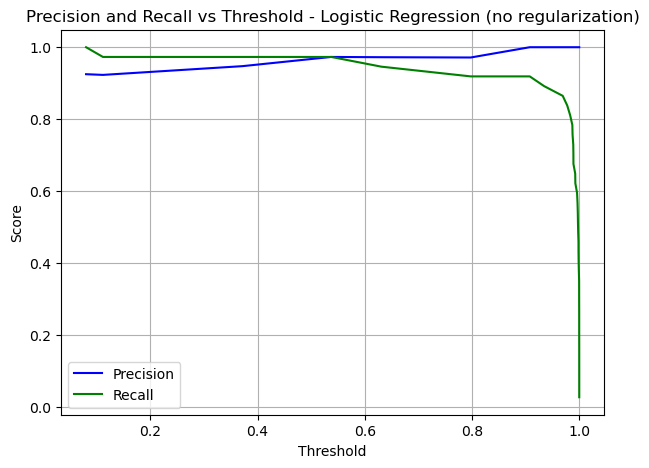


Metrics for Logistic Regression (no regularization):
accuracy: 0.9500
precision: 0.9730
recall: 0.9730
f1_score: 0.9730
roc_auc: 0.9550


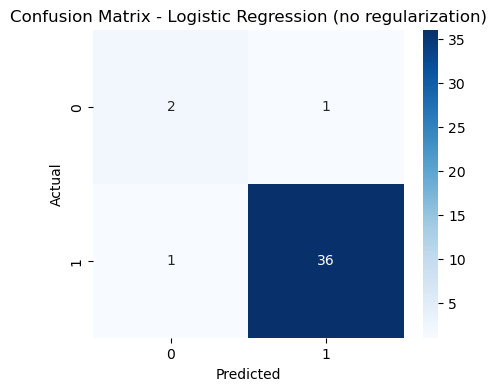

In [22]:
# 1. Logistic Regression - No Regularization
evaluate_model(LogisticRegression(penalty=None, solver='saga', max_iter=10000, random_state=42),
               "Logistic Regression (no regularization)",
               X_train, y_train, X_test, y_test)


### Regularized Logistic Regression - with L2 Penalty

c:\Users\gunav\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


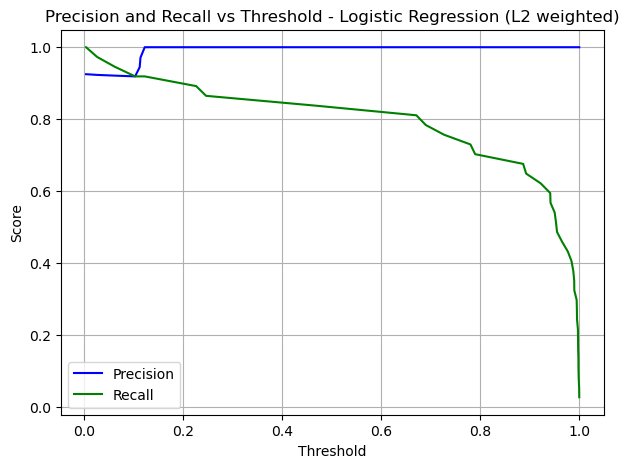


Metrics for Logistic Regression (L2 weighted):
accuracy: 0.8250
precision: 1.0000
recall: 0.8108
f1_score: 0.8955
roc_auc: 0.9189


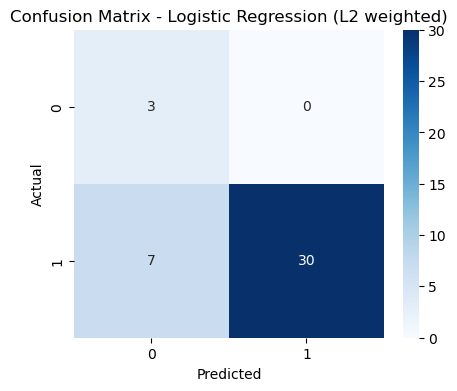

In [23]:
# 2. Logistic Regression - L2 Regularization (weighted)
evaluate_model(LogisticRegression(penalty='l2', class_weight='balanced', solver='saga', random_state=42),
               "Logistic Regression (L2 weighted)",
               X_train, y_train, X_test, y_test)

### Decision Tree

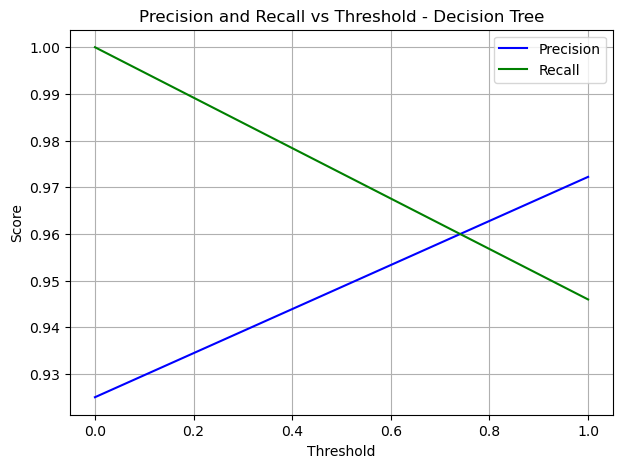


Metrics for Decision Tree:
accuracy: 0.9250
precision: 0.9722
recall: 0.9459
f1_score: 0.9589
roc_auc: 0.8063


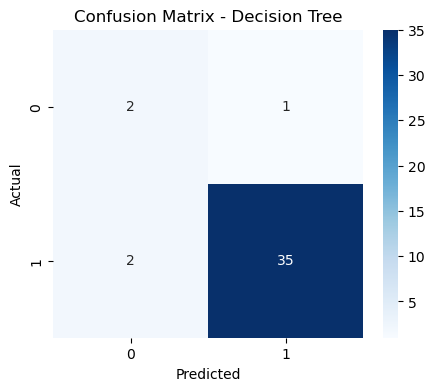

In [24]:
# 3. Decision Tree
evaluate_model(DecisionTreeClassifier(class_weight='balanced', random_state=42),
               "Decision Tree",
               X_train, y_train, X_test, y_test)

### Random Forest

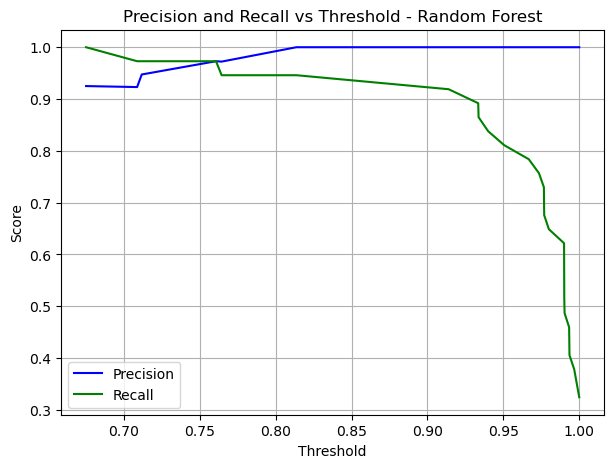


Metrics for Random Forest:
accuracy: 0.9250
precision: 0.9250
recall: 1.0000
f1_score: 0.9610
roc_auc: 0.9640


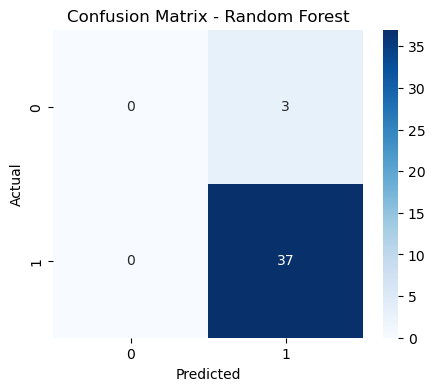

In [25]:
# 4. Random Forest
evaluate_model(RandomForestClassifier(n_estimators=300, max_depth=8, class_weight='balanced', random_state=42),
               "Random Forest",
               X_train, y_train, X_test, y_test)

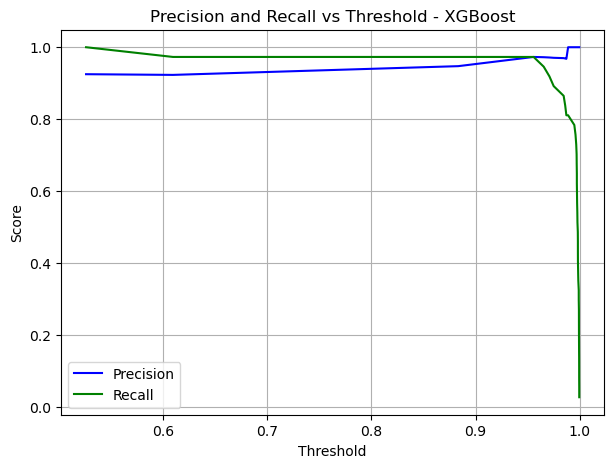


Metrics for XGBoost:
accuracy: 0.9250
precision: 0.9250
recall: 1.0000
f1_score: 0.9610
roc_auc: 0.9189


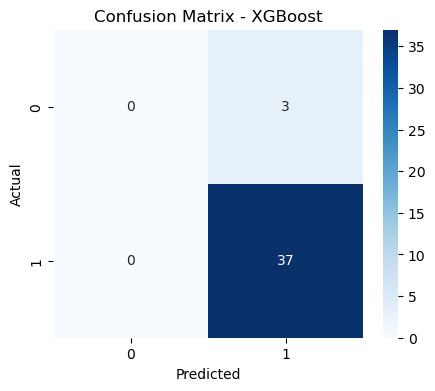

In [26]:
# 5. XGBoost
evaluate_model(XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.05,
                             eval_metric='logloss', random_state=42),
               "XGBoost",
               X_train, y_train, X_test, y_test)

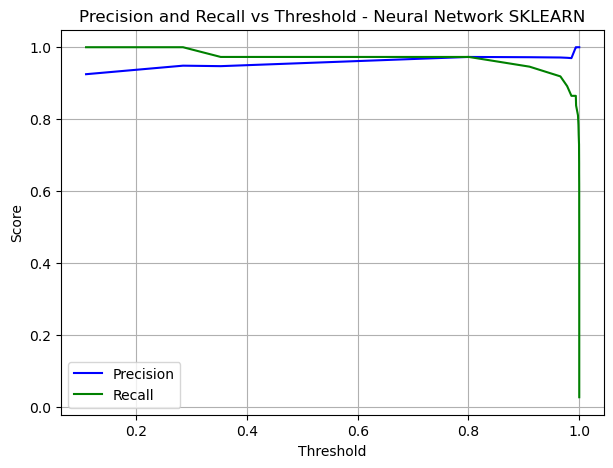


Metrics for Neural Network SKLEARN:
accuracy: 0.9500
precision: 0.9730
recall: 0.9730
f1_score: 0.9730
roc_auc: 0.9459


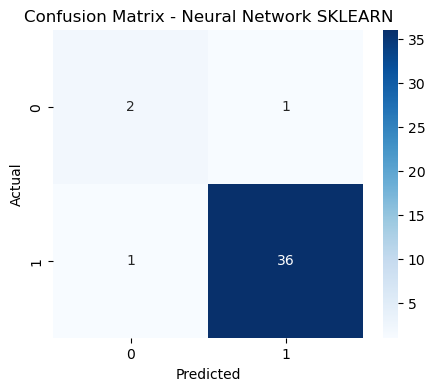

In [27]:
# 6. Neural Network (MLP)
evaluate_model(MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42),
               "Neural Network SKLEARN",
               X_train, y_train, X_test, y_test)

c:\Users\gunav\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\gunav\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Metrics for TensorFlow Neural Network (1 hidden layer):
Accuracy: 0.9250
Precision: 0.9250
Recall: 1.0000
F1-score: 0.9610
ROC-AUC: 0.9820


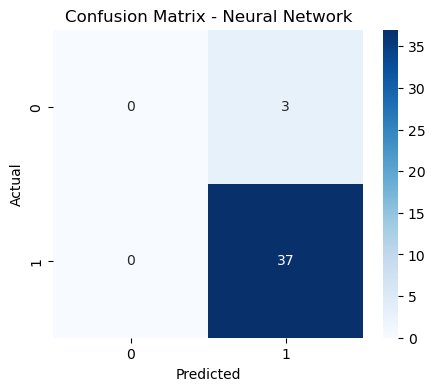

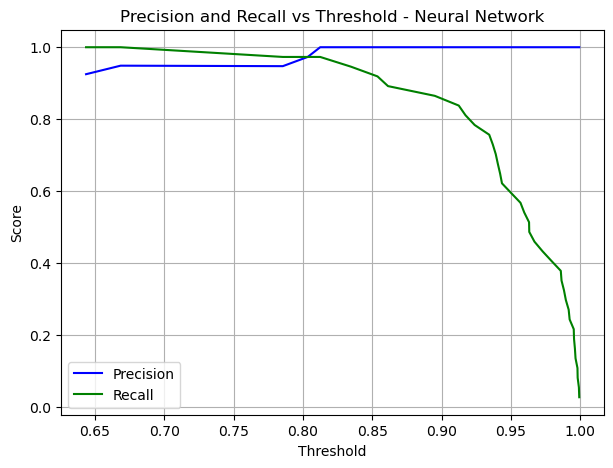

In [28]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already prepared and scaled

# 1. Build simple sequential network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # One hidden layer with 64 units
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# 2. Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# 4. Predict probabilities and class labels
y_proba = model.predict(X_test).flatten()
y_pred = (y_proba >= 0.5).astype(int)

# 5. Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

print("Metrics for TensorFlow Neural Network (1 hidden layer):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

# 7. Precision-Recall curve vs Threshold
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision_vals[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall_vals[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold - Neural Network')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pd.DataFrame(model_metrics) # display metrics for all models

,Logistic Regression (no regularization),Logistic Regression (L2 weighted),Decision Tree,Random Forest,XGBoost,Neural Network SKLEARN
accuracy,0.95,0.825,0.925,0.925,0.925,0.95
precision,0.972973,1.0,0.972222,0.925,0.925,0.972973
recall,0.972973,0.810811,0.945946,1.0,1.0,0.972973
f1_score,0.972973,0.895522,0.958904,0.961039,0.961039,0.972973
roc_auc,0.954955,0.918919,0.806306,0.963964,0.918919,0.945946
pr_curve,"([0.925, 0.9230769230769231, 0.947368421052631...","([0.925, 0.9230769230769231, 0.921052631578947...","([0.925, 0.9722222222222222, 1.0], [1.0, 0.945...","([0.925, 0.9230769230769231, 0.947368421052631...","([0.925, 0.9230769230769231, 0.947368421052631...","([0.925, 0.9487179487179487, 0.947368421052631..."


## 4.3. Model Evaluation

| Model                             | Accuracy | Precision | Recall | F1-score | ROC-AUC |
| --------------------------------- | -------- | --------- | ------ | -------- | ------- |
| Logistic Regression (no reg)      | 0.9500   | 0.9730    | 0.9730 | 0.9730   | 0.9550  |
| Logistic Regression (L2 weighted) | 0.8250   | 1.0000    | 0.8108 | 0.8955   | 0.9189  |
| Decision Tree                     | 0.9250   | 0.9722    | 0.9459 | 0.9589   | 0.8063  |
| Random Forest                     | 0.9250   | 0.9250    | 1.0000 | 0.9610   | 0.9640  |
| XGBoost                           | 0.9250   | 0.9250    | 1.0000 | 0.9610   | 0.9189  |
| Neural Network (sklearn MLP)      | 0.9500   | 0.9730    | 0.9729 | 0.9730   | 0.9459  |
| Neural Network (TensorFlow 1HL)   | 0.9250   | 0.9250    | 1.0000 | 0.9610   | 0.9820  |

---

### Observations

1. **Best Accuracy & F1-score**:

   * Logistic Regression (no regularization) and sklearn Neural Network (MLP) achieved the **highest accuracy (0.95)** and **F1-score (~0.973)**.

2. **Recall vs Precision trade-off**:

   * TensorFlow Neural Network and tree-based models (Random Forest, XGBoost) have **perfect recall (1.0)**, but slightly lower precision (~0.925).
   * Logistic Regression (L2 weighted) is extremely precise (1.0) but misses some positives (recall 0.8108).

3. **ROC-AUC**:

   * TensorFlow Neural Network achieved **highest ROC-AUC (0.982)**, indicating excellent discrimination between classes.
   * Decision Tree has lower ROC-AUC (0.8063), despite good F1-score.

4. **Sklearn MLP vs TensorFlow**:

   * Both are similar in architecture, but **different frameworks, initialization, and optimization** lead to slight metric differences.
   * TensorFlow gives slightly better ROC-AUC, but sklearn MLP has slightly higher F1-score.

5. **Tree-based models**:

   * Random Forest and XGBoost achieve **perfect recall**, which is important for highly skewed datasets, but precision is slightly lower, leading to a lower F1-score compared to logistic regression.

---

### Conclusion

* For **balanced performance** (accuracy, precision, recall, F1, ROC-AUC), **Logistic Regression (no regularization) or sklearn Neural Network** are top choices.
* For **maximizing recall** (capturing all price-up movements), **Random Forest, XGBoost, or TensorFlow Neural Network** are better.
* Choice of model depends on business priority:

  * **Precision-focused** → Logistic Regression (weighted)
  * **Recall-focused** → TensorFlow NN, Random Forest, XGBoost
* Overall, **even simple models perform very well** due to the informative features and engineered technical indicators in the dataset.

---


## 4.4 Analysis & Financial Interpretation

### 1. Why Logistic Regression Performs Reasonably Good or Bad

**Observations from results:**

* Logistic Regression (no regularization) achieved **high accuracy (~0.95)** and **high F1 (~0.973)**.
* Weighted L2 Logistic Regression improves handling of class imbalance but slightly reduces recall.

**Reasons:**

* **Good performance**: Logistic regression works well because the target is strongly associated with **binary features** (`high_volatility`, `trend_continuation`) and other technical features, which can be linearly separated.
* **Potential issues**: Without regularization, quasi-complete separation (minority class concentrated in very few cells, e.g., `trend_continuation=1 & future_trend=0`) can cause **unstable coefficient estimates**.
* **Class imbalance handling** is crucial: the dataset is **heavily skewed** (`future_trend=1` is 187 vs 0 is 13). Weighted logistic regression addresses this but can reduce precision slightly.

**Conclusion:** Logistic Regression performs well for **linear relationships** and strong binary signals but may struggle if feature interactions or non-linearities dominate.

---

### 2. Why Neural Network Performs Better or Worse

**Observations from results:**

* TensorFlow NN and sklearn MLP achieve **perfect recall** for some models and high ROC-AUC (~0.982).
* Slightly lower precision (~0.925) for deep models compared to logistic regression.

**Reasons:**

* **Better**: Neural networks can capture **non-linear interactions** between numerical features like `technical_score`, `slope_strength`, `candlestick_variance`, etc., which logistic regression cannot.
* **Worse**: In some cases, overfitting can occur, especially with **small minority class counts**, leading to lower precision. Dropout or regularization is necessary to stabilize performance.
* **Random initialization** and training dynamics cause slight differences between sklearn MLP and TensorFlow implementations.

**Conclusion:** Neural networks are powerful for capturing non-linear patterns but require careful handling of **imbalanced classes** and small sample effects.

---

### 3. Effect of Volatility on Predictions (`high_volatility`)

| high_volatility | future_trend=0 | future_trend=1 |
| --------------- | -------------- | -------------- |
| 0               | 1              | 127            |
| 1               | 12             | 60             |

**Interpretation:**

* Low volatility (`0`) mostly aligns with **future_trend=1**, which makes prediction easier.
* High volatility (`1`) contains **more mix** (12 down vs 60 up), which increases **prediction uncertainty**.

**Modeling impact:**

* `high_volatility` is **highly informative** but introduces quasi-separation risk.
* Logistic regression coefficients for this feature may be very large without regularization.

---

### 4. Role of Trend Continuation (`trend_continuation`)

| trend_continuation | future_trend=0 | future_trend=1 |
| ------------------ | -------------- | -------------- |
| 0                  | 12             | 66             |
| 1                  | 1              | 121            |

**Interpretation:**

* Trend continuation strongly correlates with **future_trend=1**.
* Cases with `trend_continuation=0` have a mix, mostly uptrend, but a few downtrend samples increase uncertainty.

**Modeling impact:**

* This feature carries **very strong signal** for predicting uptrends.
* Logistic regression without regularization could overfit due to quasi-complete separation.

---

### 5. Situations Where the Model Fails and Why

**Potential failure cases:**

1. **High volatility with downtrend (`high_volatility=1` and `future_trend=0`)**

   * Very few samples (12) → model may **misclassify minority cases**.
2. **No trend continuation but downtrend (`trend_continuation=0` and `future_trend=0`)**

   * Rare occurrences (12 out of 13 downtrends) → prediction may fail due to small sample size.
3. **Complex non-linear interactions among numerical features**

   * Logistic regression may fail to capture interactions between `slope_strength`, `candlestick_variance`, `pattern_symmetry`, etc., leading to reduced performance in borderline cases.

**Why:**

* Skewed target distribution (`future_trend=1` dominates)
* Quasi-complete separation in binary features
* Small sample size for minority class → instability in coefficients and predictions

---

### Final Conclusion

1. **Binary features** (`high_volatility`, `trend_continuation`) dominate predictive power.
2. **Logistic Regression** works well due to linear separability but needs **regularization** and **class weighting**.
3. **Neural Networks** can capture **non-linear interactions**, achieving high recall and ROC-AUC but slightly lower precision.
4. **High volatility** increases uncertainty; models are more likely to misclassify rare downtrends.
5. **Trend continuation** is a very strong predictor of uptrends.
6. **Model failures** mostly occur for **minority class combinations** with very few samples.

**Recommendation:**

* Use **class-weighted regularized logistic regression** for interpretability.
* Use **deep neural networks or tree-based models** when non-linear patterns are important.
* Always monitor **rare combinations of binary features** to prevent overconfidence in predictions.

---
